### Данная тетрадка подготовлена Степаном Зиминым (tg @smzimin) и используется с его согласия. 

# Backtesting

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms and Q-Q plots
    
    
- Recap: Market risk metrics
    - Value-at-Risk
    - Expected Shortfall
    
    
- Calculating VaR over historical period
    - Historical Simulation
    - Parametric estimation: Normal, t-Student
    
    
- Backtesting VaR curve
    - Bernoulli coverage test
    - Independence test
    
    
    
## References
- [Risk Measures](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-4.pdf)
- [Univariate Volatility Modeling](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-2.pdf)

In [12]:
import numpy as np
import pandas as pd
from datetime import datetime

import statsmodels.api as sm
import seaborn as sns
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

# QQ, PP, Prob

In [3]:
# Общие настройки
np.random.seed(42)
x = np.linspace(-4, 4, 100)  # Для теоретической нормальной плотности


# QQ

<Figure size 800x600 with 0 Axes>

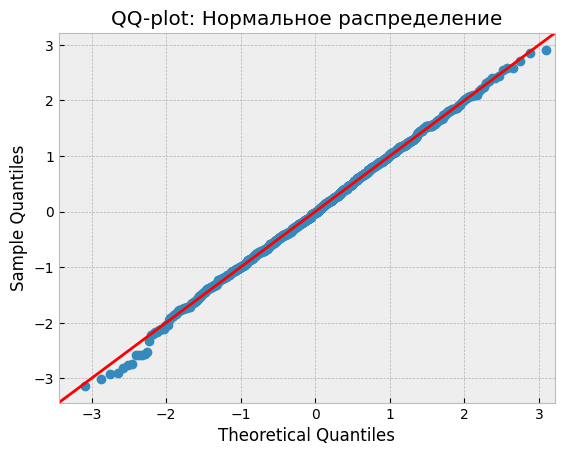

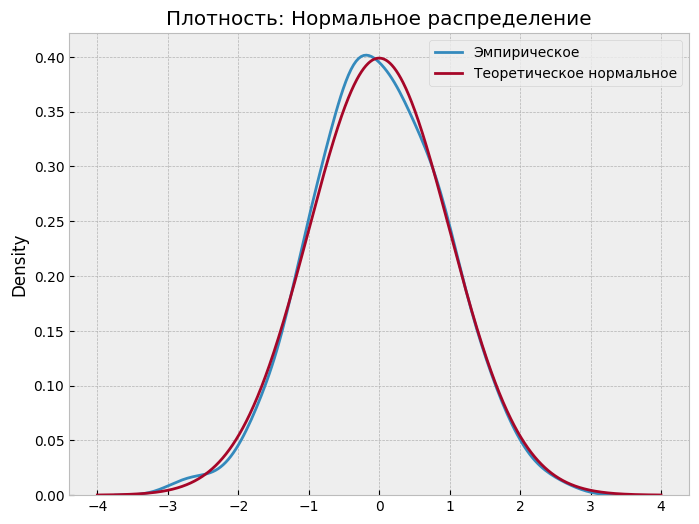

In [13]:

# 1. Нормальное распределение
normal_data = np.random.normal(loc=0, scale=1, size=1000)

# QQ-plot
plt.figure(figsize=(8, 6))
sm.qqplot(normal_data, line='45', fit=True)
plt.title('QQ-plot: Нормальное распределение')
plt.show()

# Плотность
plt.figure(figsize=(8, 6))
sns.kdeplot(normal_data, label='Эмпирическое')
plt.plot(x, stats.norm.pdf(x), label='Теоретическое нормальное')
plt.title('Плотность: Нормальное распределение')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

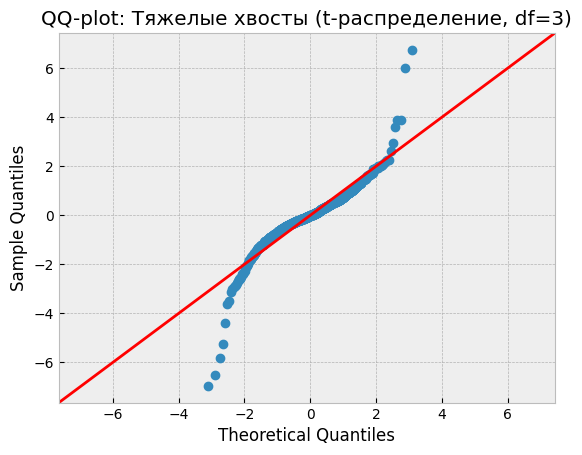

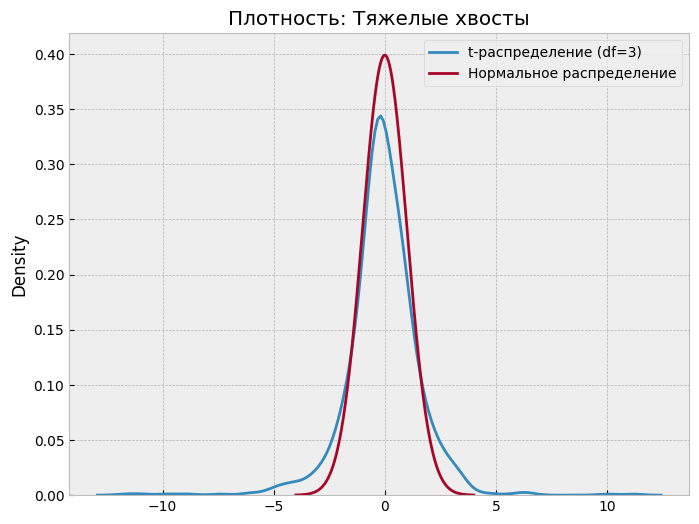

In [14]:

# 2. Тяжелые хвосты (t-распределение с 3 степенями свободы)
heavy_tailed = np.random.standard_t(3, 1000)

# QQ-plot
plt.figure(figsize=(8, 6))
sm.qqplot(heavy_tailed, line='45', fit=True)
plt.title('QQ-plot: Тяжелые хвосты (t-распределение, df=3)')
plt.show()

# Плотность
plt.figure(figsize=(8, 6))
sns.kdeplot(heavy_tailed, label='t-распределение (df=3)')
plt.plot(x, stats.norm.pdf(x), label='Нормальное распределение')
plt.title('Плотность: Тяжелые хвосты')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

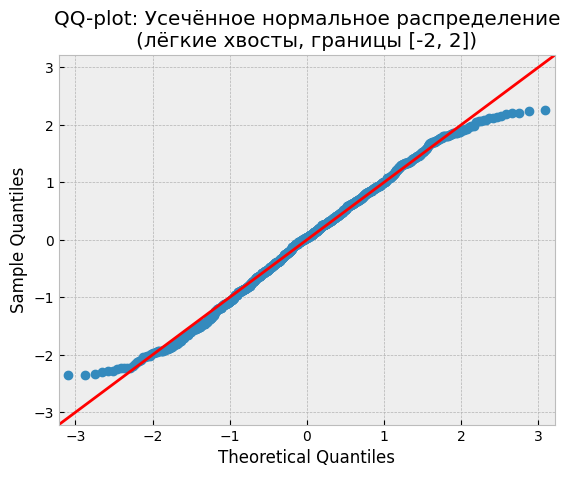

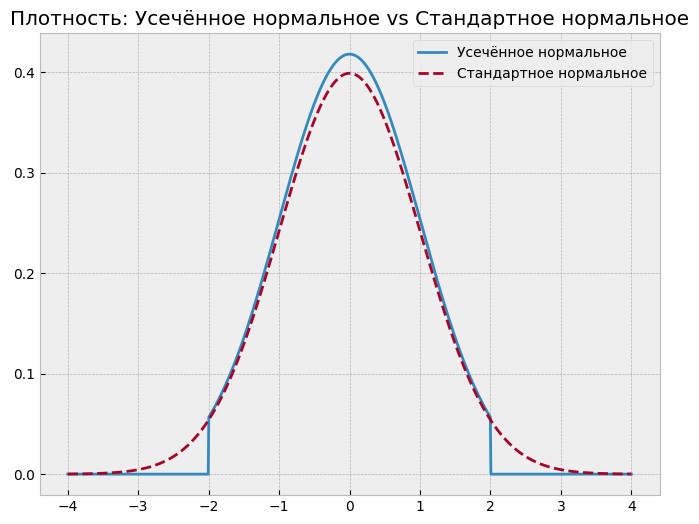

In [15]:
from scipy.stats import truncnorm

# Генерация усечённого нормального распределения (лёгкие хвосты)
a, b = -2, 2  # Границы усечения
loc, scale = 0, 1  # Параметры нормального распределения
size = 1000

# Генерация данных
trunc_normal = truncnorm(a, b, loc=loc, scale=scale).rvs(size)

# 1. QQ-plot
plt.figure(figsize=(8, 6))
sm.qqplot(trunc_normal, line='45', fit=True)
plt.title('QQ-plot: Усечённое нормальное распределение\n(лёгкие хвосты, границы [-2, 2])')
plt.show()

# 2. Плотность распределения
plt.figure(figsize=(8, 6))
x = np.linspace(-4, 4, 1000)

# Теоретическая плотность усечённого нормального
plt.plot(x, truncnorm.pdf(x, a, b, loc, scale), 
         label='Усечённое нормальное', linewidth=2)

# Стандартное нормальное для сравнения
plt.plot(x, stats.norm.pdf(x, loc, scale), 
         label='Стандартное нормальное', linestyle='--')

plt.title('Плотность: Усечённое нормальное vs Стандартное нормальное')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

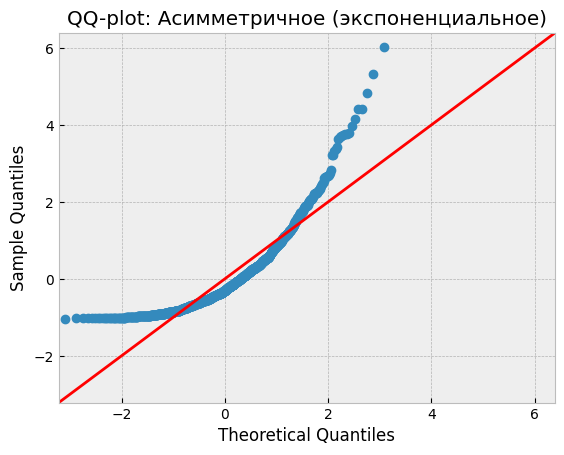

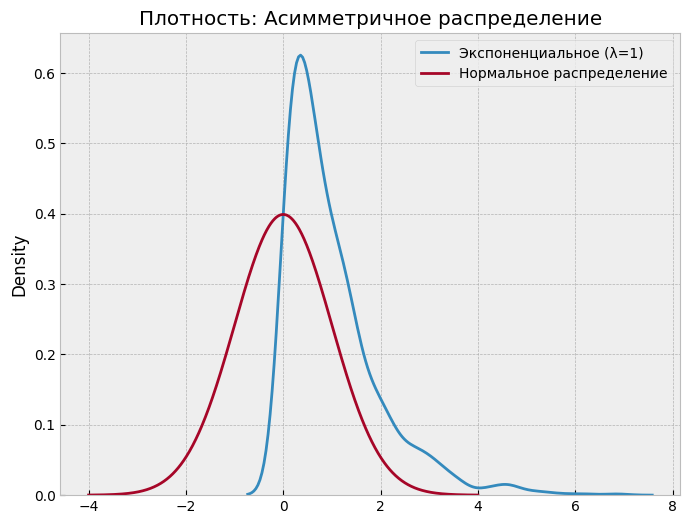

In [16]:

# 4. Асимметричное распределение (экспоненциальное)
asymmetric = np.random.exponential(scale=1, size=1000)

# QQ-plot
plt.figure(figsize=(8, 6))
sm.qqplot(asymmetric, line='45', fit=True)
plt.title('QQ-plot: Асимметричное (экспоненциальное)')
plt.show()

# Плотность (только положительные значения)
plt.figure(figsize=(8, 6))
sns.kdeplot(asymmetric, label='Экспоненциальное (λ=1)')
plt.plot(x, stats.norm.pdf(x), label='Нормальное распределение')
plt.title('Плотность: Асимметричное распределение')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

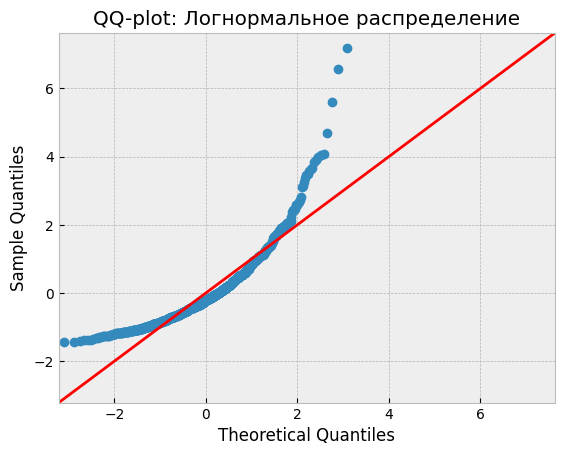

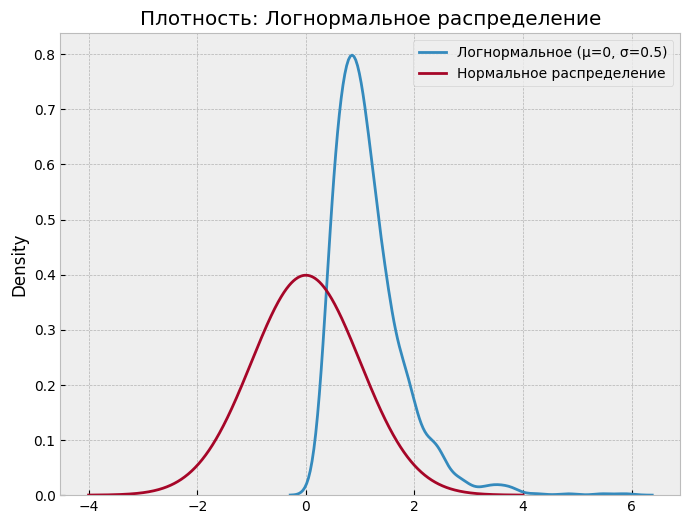

In [11]:
# 5. Логнормальное распределение (асимметрия + тяжелые хвосты)
lognormal = np.random.lognormal(mean=0, sigma=0.5, size=1000)

# QQ-plot
plt.figure(figsize=(8, 6))
sm.qqplot(lognormal, line='45', fit=True)
plt.title('QQ-plot: Логнормальное распределение')
plt.show()

# Плотность (только положительные значения)
plt.figure(figsize=(8, 6))
sns.kdeplot(lognormal, label='Логнормальное (μ=0, σ=0.5)')
plt.plot(x, stats.norm.pdf(x), label='Нормальное распределение')
plt.title('Плотность: Логнормальное распределение')
plt.legend()
plt.show()

## Data

### Upload and visualize data

**Task: download daily data for any company you want, so that you have at least 2 years of history**

In [18]:
import yfinance as yf

prices = yf.download('AAPL','2016-01-01','2024-04-16')

prices.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,


In [28]:
prices = pd.read_csv("apple.csv", decimal=",")
prices = prices.loc[:, ("Дата", 'Цена')].rename(columns={
    'Дата': "Date",
    'Цена': "Price"
})

prices = prices.set_index('Date')
prices

,Price
Date,
17.04.2025,196.98
16.04.2025,194.27
15.04.2025,202.14
14.04.2025,202.52
11.04.2025,198.15
...,...
08.01.2020,75.80
07.01.2020,74.60
06.01.2020,74.95


**Task: do a plot of daily price**


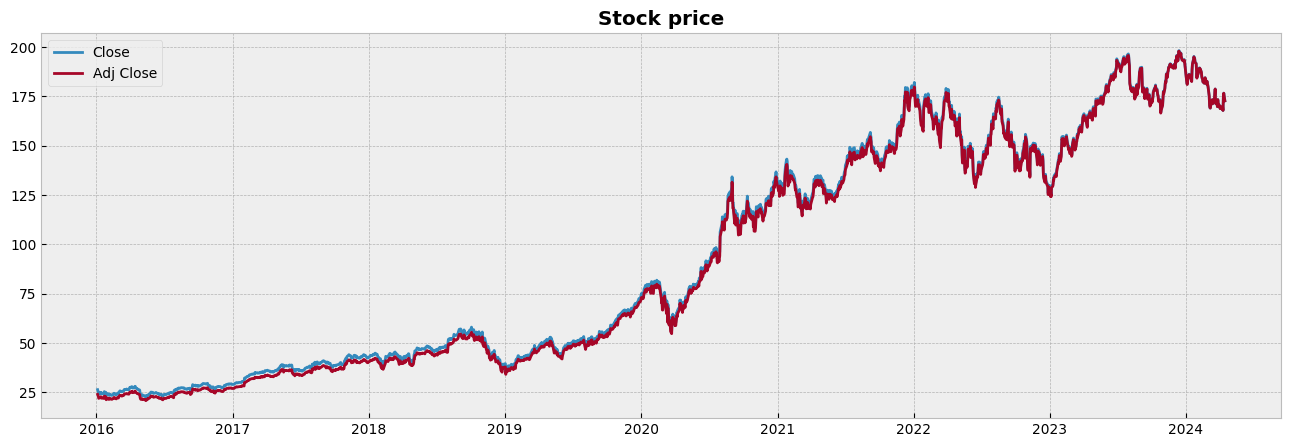

In [3]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

**Task: convert datetime index to period**

In [4]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05',
               '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11',
               '2024-04-12', '2024-04-15'],
              dtype='datetime64[ns]', name='Date', length=2084, freq=None)
PeriodIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
             '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
             '2016-01-14', '2016-01-15',
             ...
             '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05',
             '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11',
             '2024-04-12', '2024-04-15'],
            dtype='period[D]', name='Date', length=2084)


**Task: take only Adj Close price and convert it to returns**

In [29]:
price = prices['Price']

price.head()

Date
17.04.2025    196.98
16.04.2025    194.27
15.04.2025    202.14
14.04.2025    202.52
11.04.2025    198.15
Name: Price, dtype: float64

In [30]:
ret = price.pct_change()

ret

Date
17.04.2025         NaN
16.04.2025   -0.013758
15.04.2025    0.040511
14.04.2025    0.001880
11.04.2025   -0.021578
                ...   
08.01.2020   -0.020798
07.01.2020   -0.015831
06.01.2020    0.004692
03.01.2020   -0.007872
02.01.2020    0.009817
Name: Price, Length: 1331, dtype: float64

In [31]:
ret = ret.dropna()

**Task: plot a graph of daily returns**

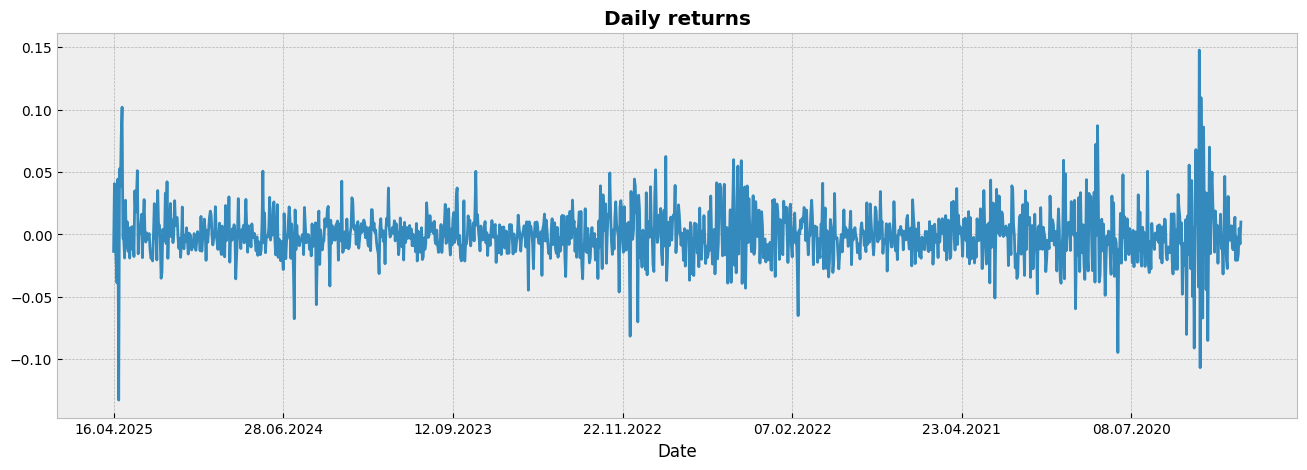

In [32]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

In [33]:
import scipy.stats as ss


### Plot histograms and Q-Q plots -- *no tasks in this section! just look at it and discuss what you see*

Explore the Returns Distribution

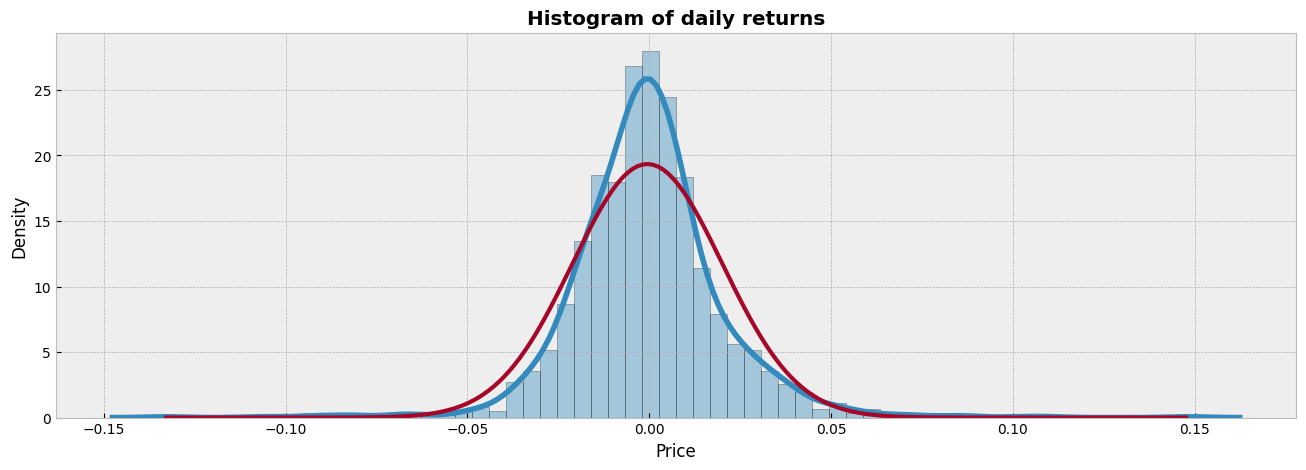

In [34]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

sns.distplot(ret, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

params_norm = ss.norm.fit(ret)
y_pdf = ss.norm.pdf(x, *params_norm)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")

plt.show()

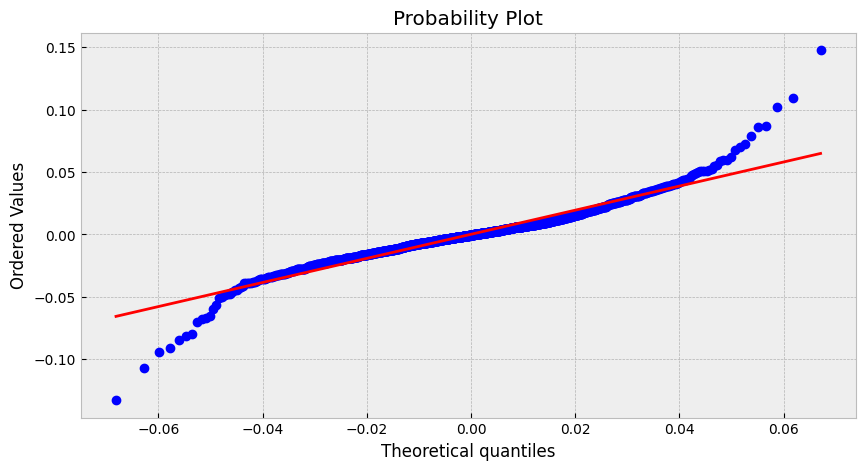

In [35]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)

plt.show()

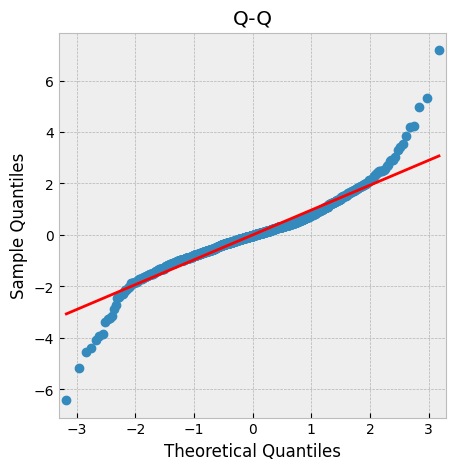

In [36]:
import statsmodels.graphics.gofplots
pp = statsmodels.graphics.gofplots.ProbPlot(ret, fit=True)

fig = plt.figure(figsize=(17, 5))

plt1 = fig.add_subplot(1,3,1)

pp.qqplot(ax=plt1.axes, line='r')
plt1.set_title('Q-Q')

plt.show()

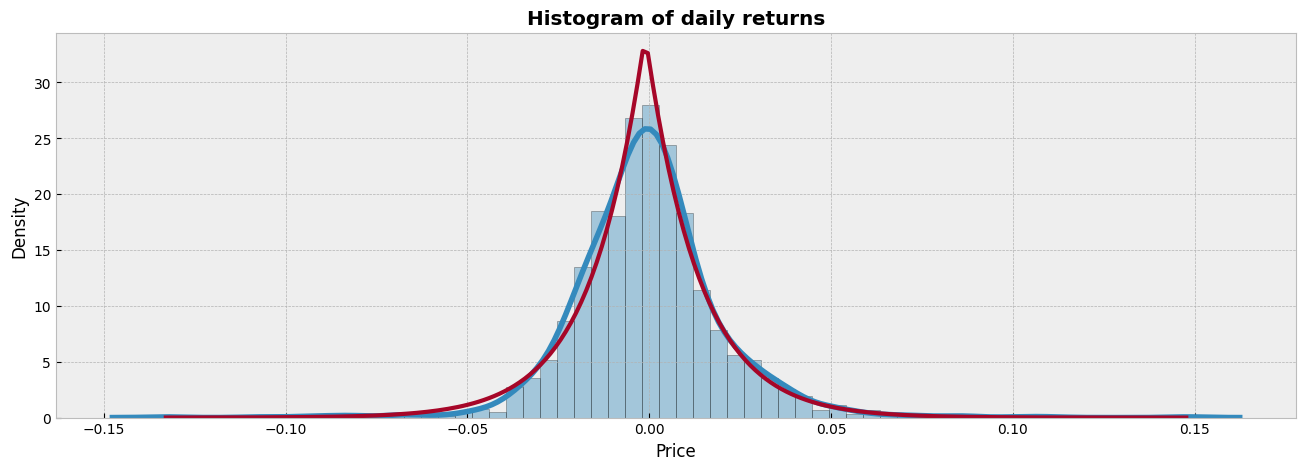

In [37]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

sns.distplot(ret, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

params_gennorm = ss.gennorm.fit(ret)
y_pdf = ss.gennorm.pdf(x, *params_gennorm)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")

plt.show()

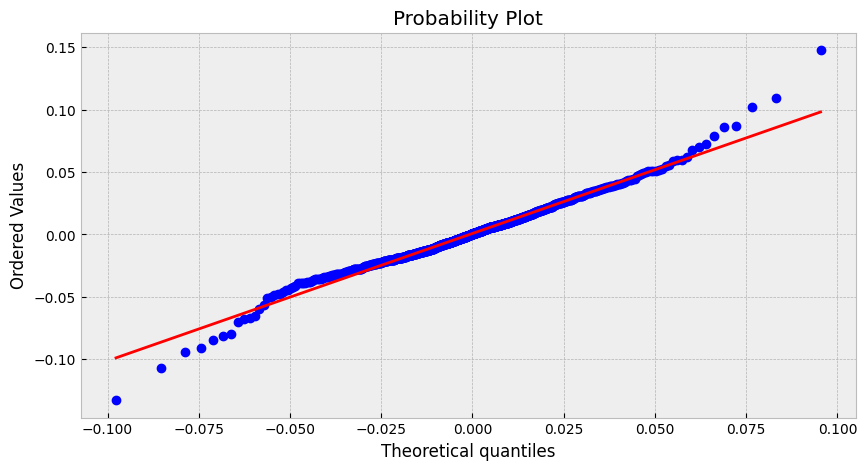

In [38]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(ret, dist=ss.gennorm(*params_gennorm), plot=plt)

plt.show()

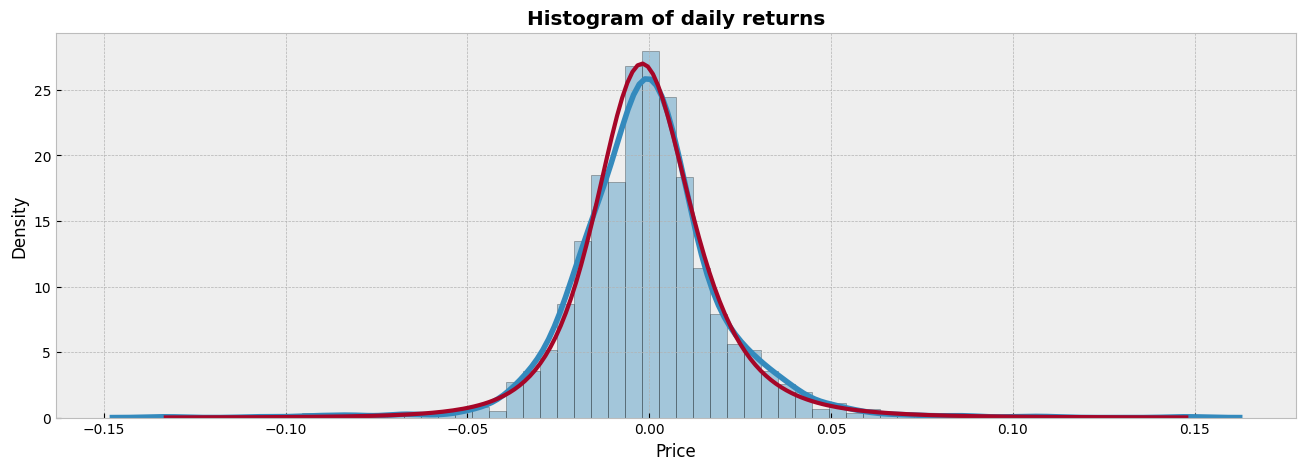

In [39]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

sns.distplot(ret, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

params_nct = ss.nct.fit(ret)
y_pdf = ss.nct.pdf(x, *params_nct)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")

plt.show()

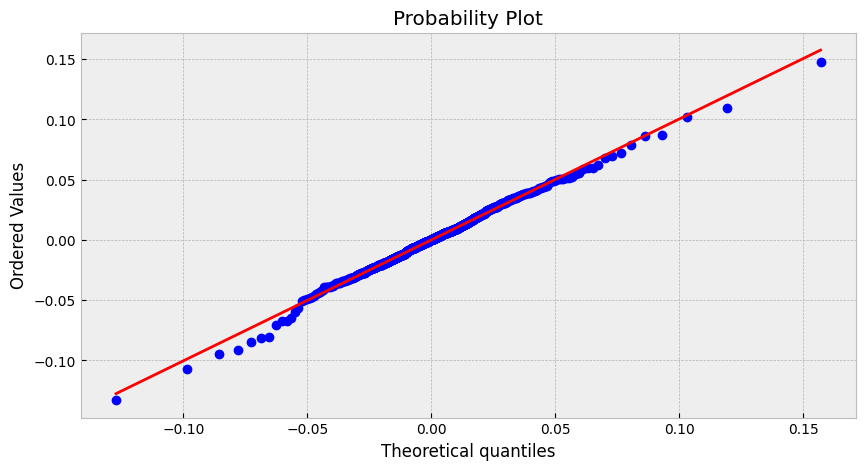

In [40]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(ret, dist=ss.nct(*params_nct), plot=plt)

plt.show()

This doesn't look very much like a normal distribution... let's check.

In [41]:

params_norm = ss.norm.fit(ret)
print(params_norm)

(np.float64(-0.0005124809312671679), np.float64(0.02061979613869991))


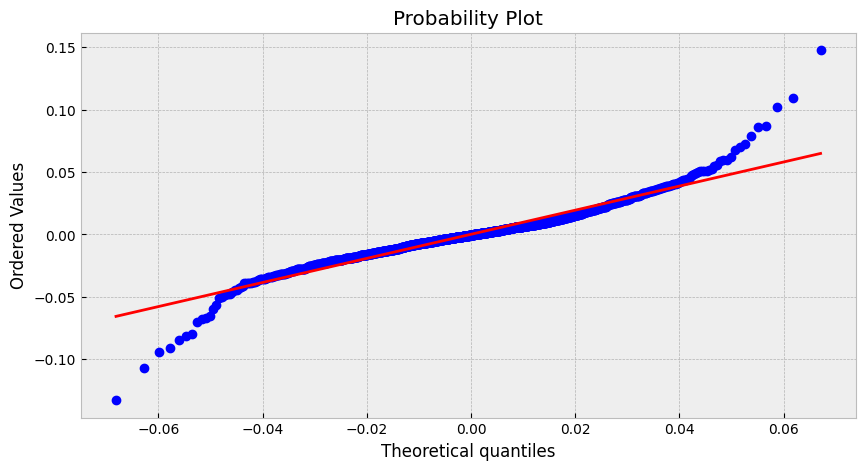

In [42]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)

plt.show()

By the way, the documentation for `ss.probplot` is misleading. This is a Q-Q plot up to the axes ticks. At least `statsmodels` calls this a Q-Q plot.

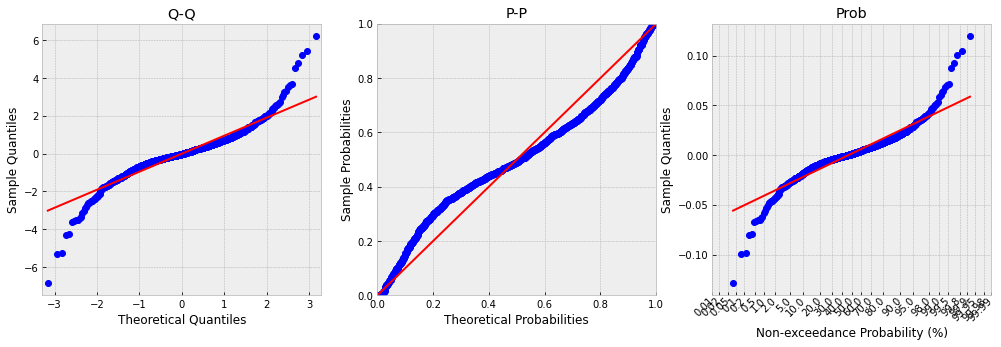

In [12]:
import statsmodels.graphics.gofplots
pp = statsmodels.graphics.gofplots.ProbPlot(ret, fit=True)

fig = plt.figure(figsize=(17, 5))

plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

pp.qqplot(ax=plt1.axes, line='r')
plt1.set_title('Q-Q')

pp.ppplot(ax=plt2.axes, line='45')
plt2.set_title('P-P')

pp.probplot(ax=plt3.axes, line='r')
plt3.set_title('Prob')

plt.show()

## Market risk metrics  -- *no tasks in this section, just a recap! just look at it and discuss what you see*


### Value-at-Risk definition and visualization


Value-at-Risk is the loss on a trading portfolio such that there is a probability $q$ of losses equaling or exceeding VaR in a given trading period and a $(1 − q)$ probability of losses being lower than the VaR.

Mathematically, VaR is a quantile on the distribution of P/L (profit and loss), or returns $r_t$:

$$\mathbf{P}[r_{t+h} \le VaR_{t+h}(q)] = q$$



VaR depends on:
1. The probability of losses exceeding VaR, $p$
2. The holding period $h$, the time period over which losses may occur
3. The probability distribution of the P/L of the portfolio

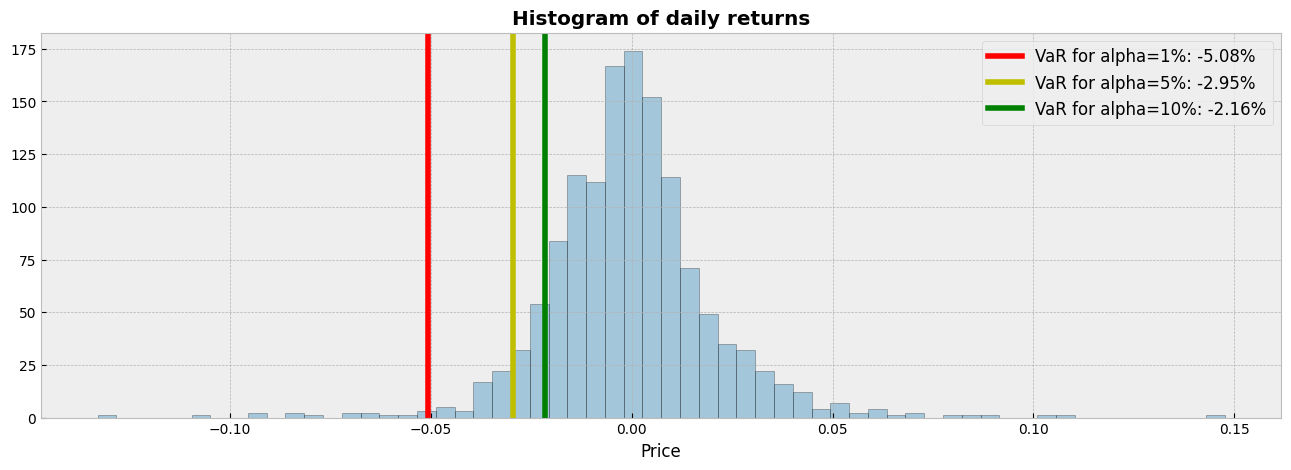

In [43]:
VaR_HS_01 = ret.quantile(0.01)
VaR_HS_05 = ret.quantile(0.05)
VaR_HS_10 = ret.quantile(0.10)

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
plt.axvline(x=VaR_HS_05, linewidth=4, color="y")
plt.axvline(x=VaR_HS_10, linewidth=4, color="g")

plt.title("Histogram of daily returns", weight="bold")

plt.legend(['VaR for alpha=1%: {:.2f}%'.format(100*VaR_HS_01),
            'VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS_05),
            'VaR for alpha=10%: {:.2f}%'.format(100*VaR_HS_10)], fontsize=12)

plt.show()

### Expected Shortfall definition and visualization


Expected Shortfall (ES) is expected loss conditional on VaR being violated (i.e. expected return $r_t$, when it is lower than negative VaR). It is aware of the shape of the tail distribution while VaR is not

Mathematically:

$$ES = \mathbf{E}[r_{t+h} | r_{t+h} \le VaR_{t+h}(q)]$$

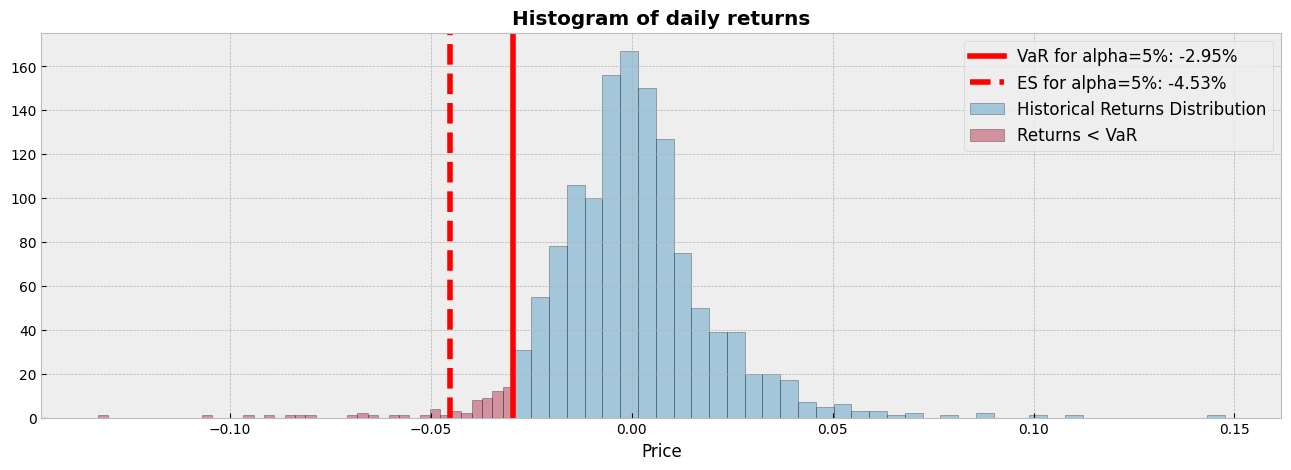

In [44]:
alpha = 0.05

VaR_HS = ret.quantile(alpha)
ES_HS = ret[ret < VaR_HS].mean()

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS, linewidth=4, color="r")
plt.axvline(ES_HS, linewidth=4, color='red', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS),
            'ES for alpha=5%: {:.2f}%'.format(100*ES_HS),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

## Calculating VaR over historical period

### Historical Simulation

Assumes that one of the observations in the estimation window will be the next days return, therefore

- VaR is the $q$'th smallest return, aka $q$'th quantile
- ES is an average of historical returns that are lower than VaR

**Task: calculate VaR curve using Historical Simulation**

Steps are:
- fix a window of length $T_w=252$
- fix some $\alpha \in (1\%, 10\%)$
- in a loop over days $t$ from $T_w+1$ to the latest day $T$
    - calculate your $VaR_t$ estimate using historical data from $t-T_w$ to $t-1$ and save to array

In [45]:
def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

In [46]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [47]:
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=50, level=alpha)

VaR_HS

Date
16.04.2025        NaN
15.04.2025        NaN
14.04.2025        NaN
11.04.2025        NaN
10.04.2025        NaN
               ...   
08.01.2020   -0.05691
07.01.2020   -0.05691
06.01.2020   -0.05691
03.01.2020   -0.05691
02.01.2020   -0.05691
Name: calculate_VaR_HS, Length: 1330, dtype: float64

**Task: plot historical returns and VaR curve**

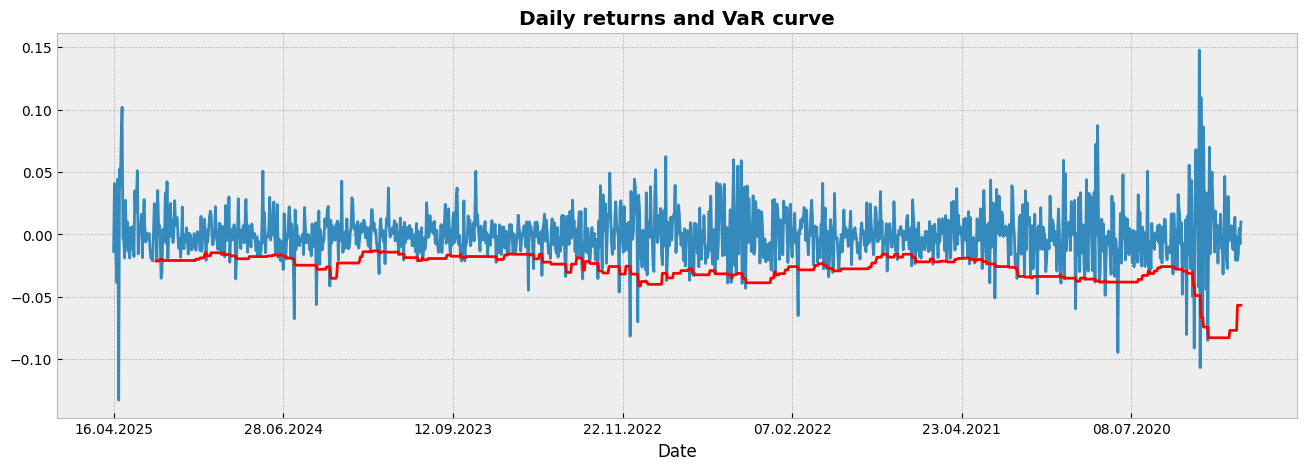

In [48]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot(color='r')

plt.title("Daily returns and VaR curve", weight="bold")

plt.show()

### Parametric estimation

In the following approaches we do not assume any correlations between $r_t$ and $r_{t+h}$, for example $r_{t+1} = \alpha r_{t} + \epsilon_t$ or something like this.

Instead, we are trying to model $r_t$ with some univariate distribution

$$r_t \sim F(x; \theta)$$

#### Normal distribution

Here we are trying to model $r_t$ with Normal distribution

$$r_t \sim N(x; \mu, \sigma^2)$$

**Task: calculate VaR curve using Normal distribution**


In [49]:
def calculate_VaR_normal(ret, alpha=0.05):

    params_norm = ss.norm.fit(ret)
    
    return ss.norm.ppf(alpha, *params_norm)

In [50]:
VaR_norm = calc_VaR(ret, calculate_VaR_normal, L_history=252, level=alpha)

#### t-Student distribution

And here - with t-Student distribution

$$r_t \sim t(\mu, \sigma^2, df)$$

**Task: calculate VaR curve using t-Student distribution**

In [51]:
def calculate_VaR_t(ret, alpha=0.05):

    params_t = ss.t.fit(ret)
    
    return ss.t.ppf(alpha, *params_t)

In [52]:
VaR_t = calc_VaR(ret, calculate_VaR_t, L_history=252, level=alpha)

**Task: plot historical returns and 3 VaR curves -- for HS, Normal and t-Student distributions**

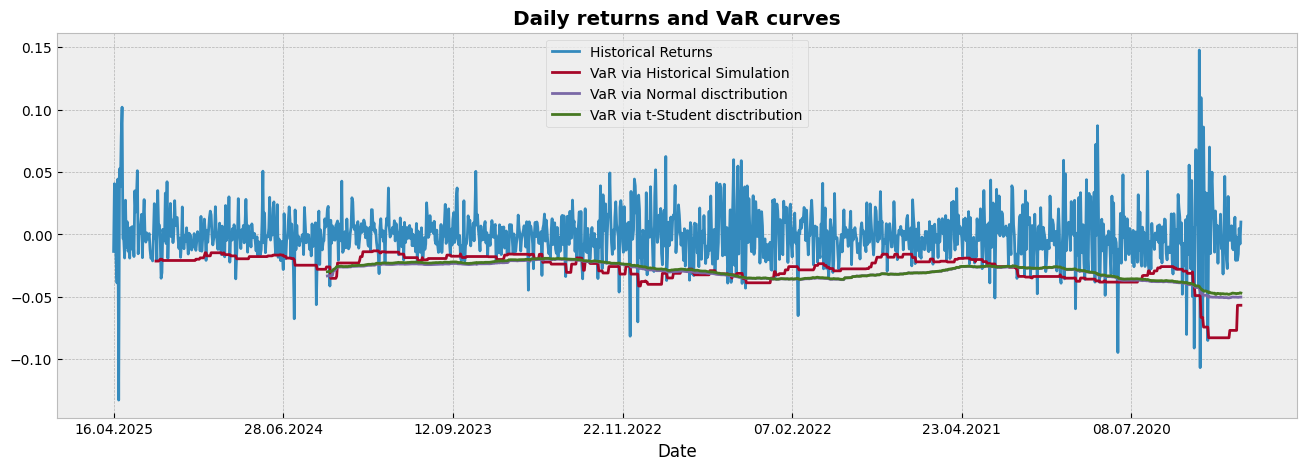

In [53]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
VaR_norm.plot()
VaR_t.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via Normal disctribution',
            'VaR via t-Student disctribution'])

plt.show()

## Backtesting VaR curve

### Bernoulli coverage test

Does the expected number of violations $\eta$, as given by $q$ match the observed number of violations?
- For a VaR(1%) backtest, we would expect to observe a violation 1% of the time
- If, violations are observed more often the VaR model is underestimating risk
- And similarly if we observe too few violations


Let 
- $\eta_t$ be one violation for one trading day -- a random variable which takes values in {0, 1},
- $v = \sum_{t=1}^T \eta_t$ be the total number of violations,
- $\hat{q} = \frac{v}{T}$ -- observed fraction of violations


The null hypothesis for VaR violations is:

$$ H_0: \eta_t \sim B(q)$$

The unrestricted likelihood function:

$$ L_U(\hat{q}) = (1-\hat{q})^{T-v}\hat{q}^{v}$$

Under $H_0, q = \hat{q}$, so the restricted likelihood function is:

$$ L_R(q) = (1-q)^{T-v}q^{v}$$


So now the testing of $q = \hat{q}$ is equivalent to testing $L_U=L_R$, and we can look at a likelihood ratio (LR)

$$LR = 2(\log L_R(q) − \log L_U(\hat{q})) \sim \chi^2(1)$$ 

For example, choosing a 5% significance level for the test, the null hypothesis is rejected if LR > 3.84

**Task: implement a function for Bernoulli coverage test, use it to test our VaR violations**

In [54]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))

### Independence test


Violations should not follow each other, because if they do, we can predict a violation today if there was one yesterday


Formulas -- please find them [here, page 77](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-8.pdf)


**Task: implement a function for Independence test, use it to test our VaR clustering**


In [55]:
def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

**Task: implement one function which combines both tests and prints info and final decision**

In [56]:
def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [63]:
backtest_results(ret, VaR_t, 0.05)

Target share of violations: 5.00%
Observed share of violations: 5.75%

Test for coverage is passed

Test for independence is passed


## Optional stuff -- Backtesting with Extreme Value Theory


#### Block maxima and Generalized Extreme Value Distribution (GEV)

Resample losses with desired period (e.g. weekly)

In [64]:
def calculate_VaR_maximas(ret, alpha=0.05):
    
    maximas = ret.resample('W').min()
    
    params_genextreme = ss.genextreme.fit(maximas)
    c, loc, scale = params_genextreme
    xi = -c

    return loc + scale / xi * (1 - (-5*np.log(1-alpha)) ** (-xi) )

#### Excess Distribution Over a Threshold

In [68]:
ret.index = pd.to_datetime(ret.index)

In [69]:
def calculate_VaR_pot(ret, alpha=0.05):
    
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)

In [70]:
VaR_pot = calc_VaR(ret, calculate_VaR_pot, L_history=252, level=alpha)
VaR_maximas = calc_VaR(ret, calculate_VaR_maximas, L_history=252, level=alpha)

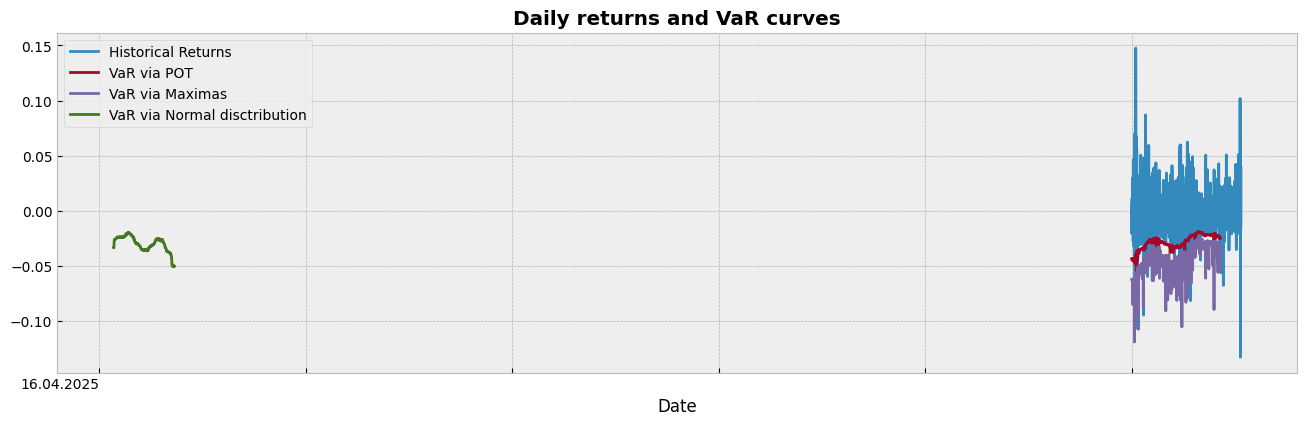

In [71]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_pot.plot()
VaR_maximas.plot()
VaR_norm.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via POT',
            'VaR via Maximas', 
           'VaR via Normal disctribution'])

plt.show()

In [ ]:
backtest_results(ret, VaR_pot, 0.05)

Target share of violations: 5.00%
Observed share of violations: 5.64%

Test for coverage is passed

Test for independence isn't passed


In [44]:
backtest_results(ret, VaR_maximas, 0.05)

Target share of violations: 5.00%
Observed share of violations: 3.59%

Test for coverage isn't passed

Test for independence isn't passed
